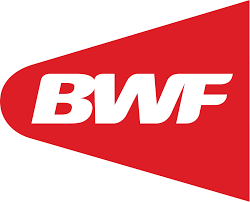

# Investigation into Optimal Badminton Strategy for Men's Singles

I love playing badminton as a sport, especially the strategic aspect of it. I would love to analyse what factors are most important in predicting the outcome of a match and devise optimal badminton strategy.

To do this, I will use dataset of badminton matches across different BWF World Tour competitions from 2018 to 2021, downloaded from kaggle.

Goal:
- Match Win Prediction and most important features
- Point by point and optimal tactic analysis

Areas for future research:
- Individual Player statistics and analysis


Referenced works:
- https://www.kaggle.com/code/juanliong/badminton-scoring-change-analysis
- https://www.kaggle.com/code/blueberry1215/badminton-home-advantage-analysis

In [1]:

# Things to explore:
# Win%
# Streak strategy, etc

# Service impact


In [2]:
# OS and file management

from pathlib import Path
import os

# Data processing and analysis
import pandas as pd
import numpy as np

from fastai import *
from kaggle import api

#Visualisations
import missingno as msno
import plotly.express as px 
import matplotlib.pyplot as plt
import seaborn as sns

#Options
pd.options.display.max_rows = 10

In [3]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [4]:
dataset_path = Path("datasets")
path = Path(os.path.join(Path("datasets"),Path("badminton-bwf-world-tour")))

In [5]:
if not path.exists():
    os.system(f"kaggle datasets download -d sanderp/badminton-bwf-world-tour -p {dataset_path}")
    ZipFile(f'{path}.zip').extractall(path)

In [6]:
os.listdir(path)

['md.csv', 'LICENSE', 'README.md', 'ms.csv', 'ws.csv', 'xd.csv', 'wd.csv']

# EDA and Processing Data

In [7]:
ms = pd.read_csv(str(path) + '/ms.csv')

In [8]:
ms.describe()

winner      nb_sets  team_one_total_points  team_two_total_points   
count  3761.000000  3761.000000            3761.000000            3761.000000  \
mean      1.459718     2.339271              41.928476              41.612603   
std       0.534488     0.493869              12.294976              12.452383   
min       0.000000     1.000000               0.000000               0.000000   
25%       1.000000     2.000000              33.000000              32.000000   
50%       1.000000     2.000000              42.000000              42.000000   
75%       2.000000     3.000000              52.000000              52.000000   
max       2.000000     3.000000              71.000000              69.000000   

       team_one_most_consecutive_points  team_two_most_consecutive_points   
count                       3761.000000                       3761.000000  \
mean                           5.665249                          5.624568   
std                            2.155618                          2.234039   
min                            0.000000                          0.000000   
25%                            4.000000                          4.000000   
50%                            5.000000                          5.000000   
75%                            7.000000                          7.000000   
max                           21.000000                         19.000000   

       team_one_game_points  team_two_game_points   
count           3761.000000           3761.000000  \
mean               2.193034              2.086413   
std                1.986514              1.946418   
min                0.000000              0.000000   
25%                0.000000              0.000000   
50%                2.000000              2.000000   
75%                3.000000              3.000000   
max               11.000000             12.000000   

       team_one_most_consecutive_points_game_1   
count                              3761.000000  \
mean                                  4.460516   
std                                   1.805016   
min                                   0.000000   
25%                                   3.000000   
50%                                   4.000000   
75%                                   5.000000   
max                                  16.000000   

       team_two_most_consecutive_points_game_1  team_one_game_points_game_1   
count                              3761.000000                  3761.000000  \
mean                                  4.437650                     0.962776   
std                                   1.864965                     1.205571   
min                                   0.000000                     0.000000   
25%                                   3.000000                     0.000000   
50%                                   4.000000                     1.000000   
75%                                   5.000000                     2.000000   
max                                  15.000000                     9.000000   

       team_two_game_points_game_1  team_one_most_consecutive_points_game_2   
count                  3761.000000                              3723.000000  \
mean                      0.896570                                 4.483212   
std                       1.173144                                 1.909400   
min                       0.000000                                 0.000000   
25%                       0.000000                                 3.000000   
50%                       1.000000                                 4.000000   
75%                       1.000000                                 5.000000   
max                       9.000000                                18.000000   

       team_two_most_consecutive_points_game_2  team_one_game_points_game_2   
count                              3723.000000                  3723.000000  \
mean                                  4.405050                     0.912168  

### Cleaning

1. Identifying missing values

<Axes: >

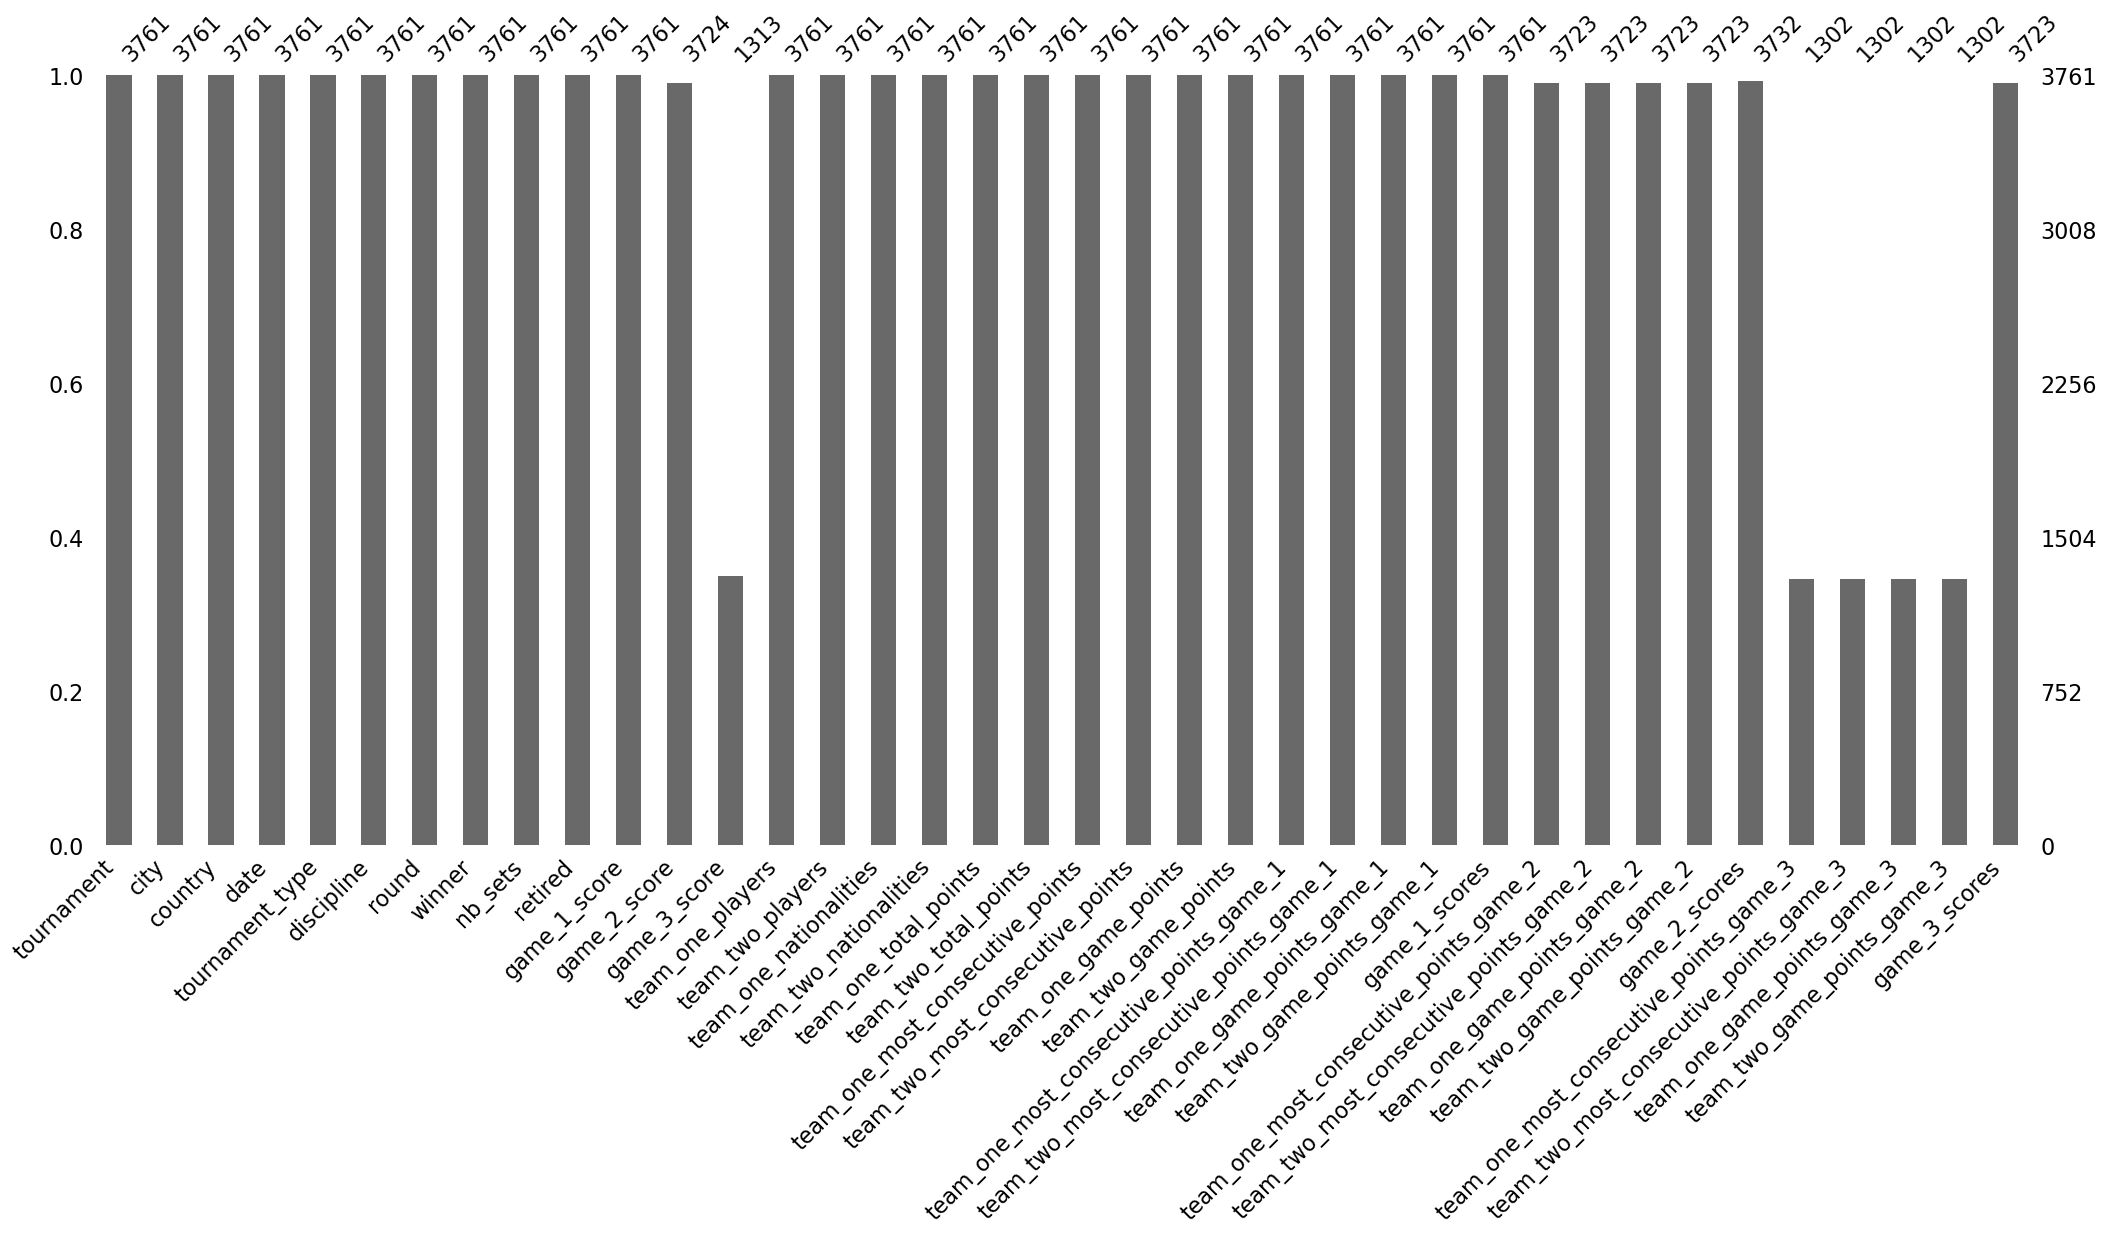

In [9]:
msno.bar(ms)

<Axes: >

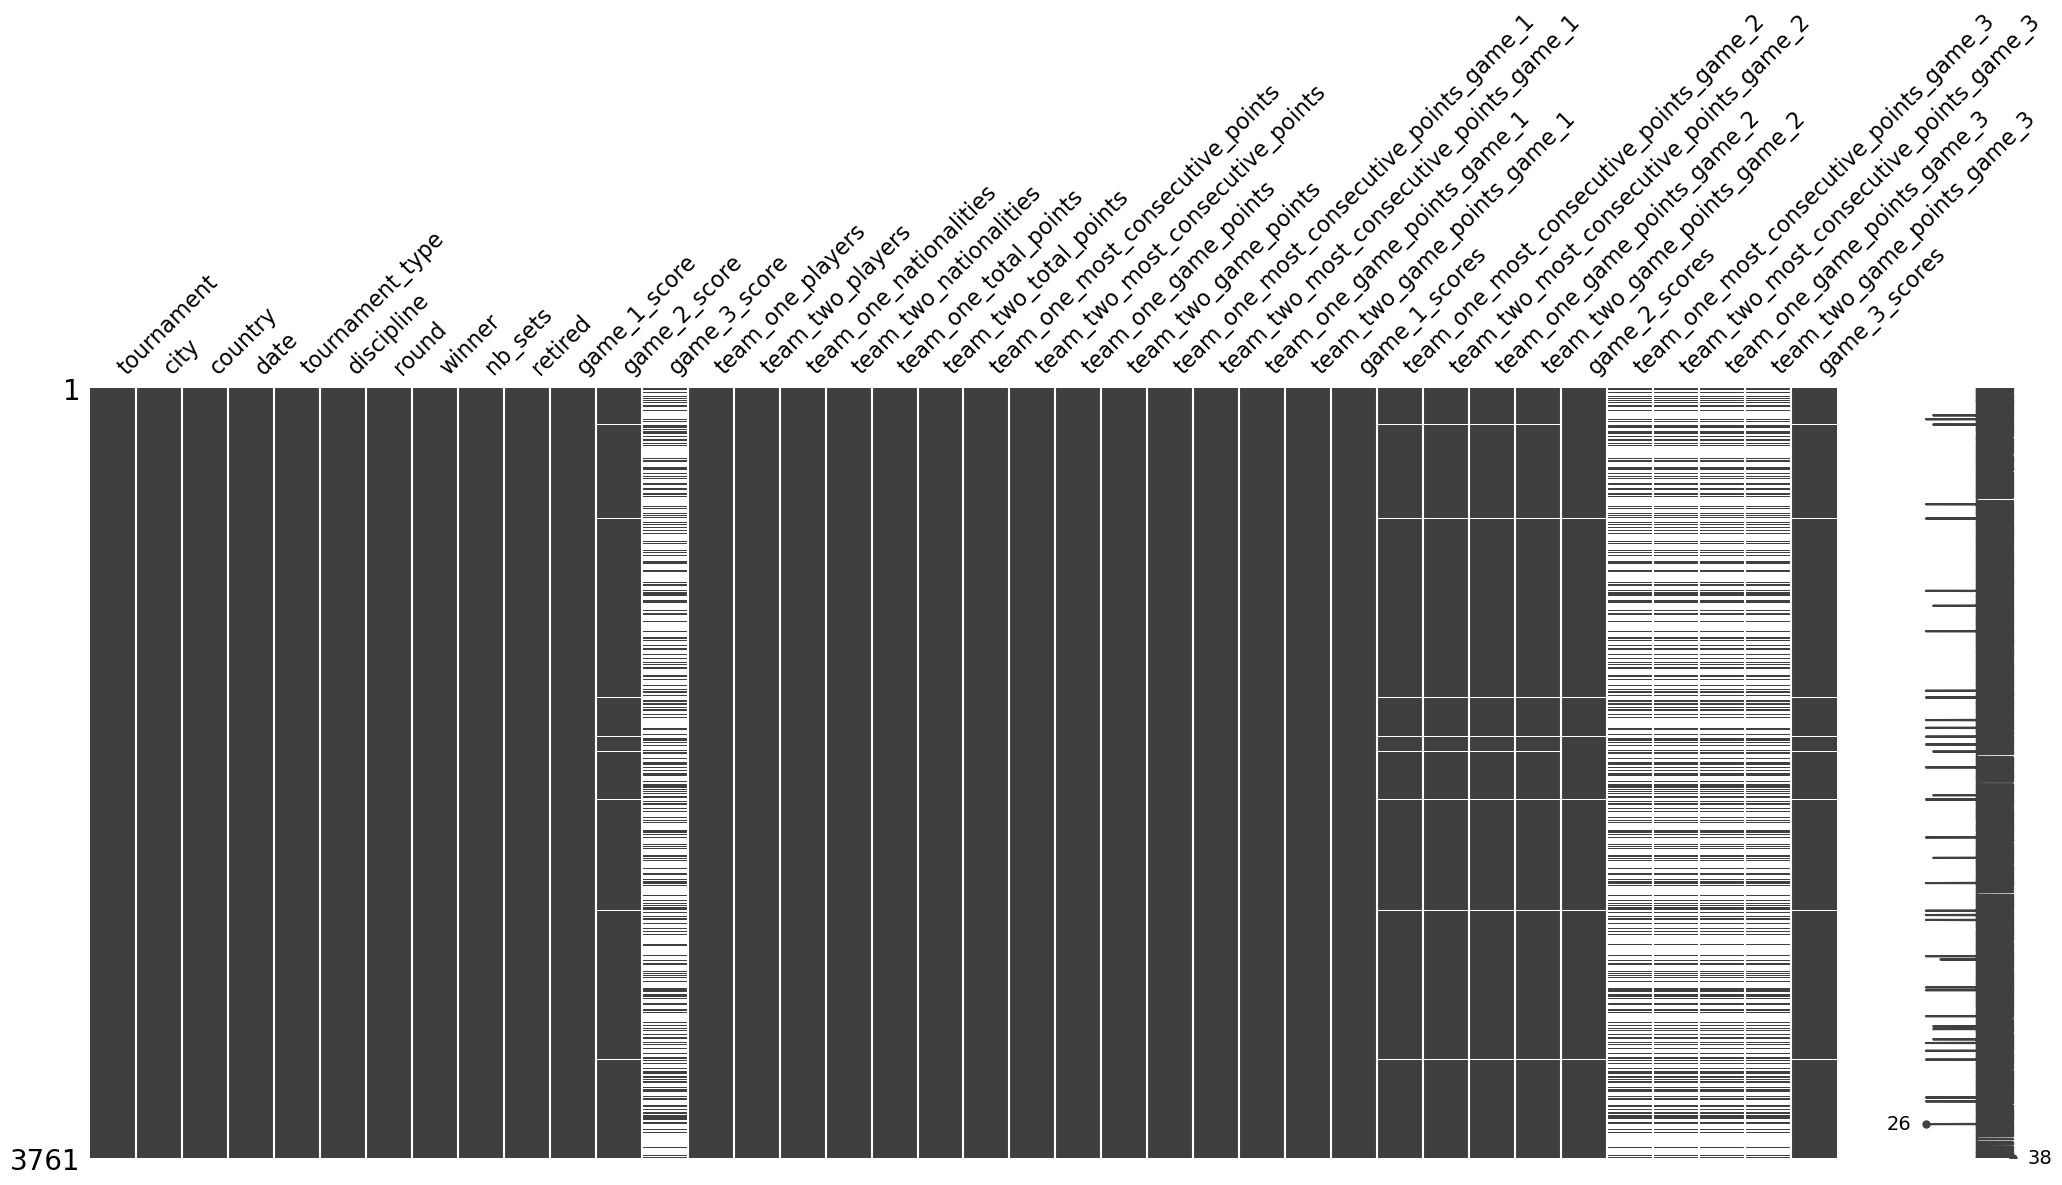

In [10]:
msno.matrix(ms)

We see that a bunch of games are incomplete, due to retirements. Also row number 28 is missing values, so we will drop those as well.

2. Filtering out retirements and incomplete games

Removing the total point count, because that would be an accurate predictor of match outcomes

In [11]:
drop_colmumns = ['country','team_one_total_points','team_two_total_points']

In [12]:
def filter_incomplete(df):
    '''
    Filter out incomplete games. 
    '''
    df = df.copy()
    df = df[df.retired == False]
    df.reset_index(inplace = True)
    df.drop(columns = 'index', inplace = True)
    return df

In [13]:
ms = filter_incomplete(ms)

<Axes: >

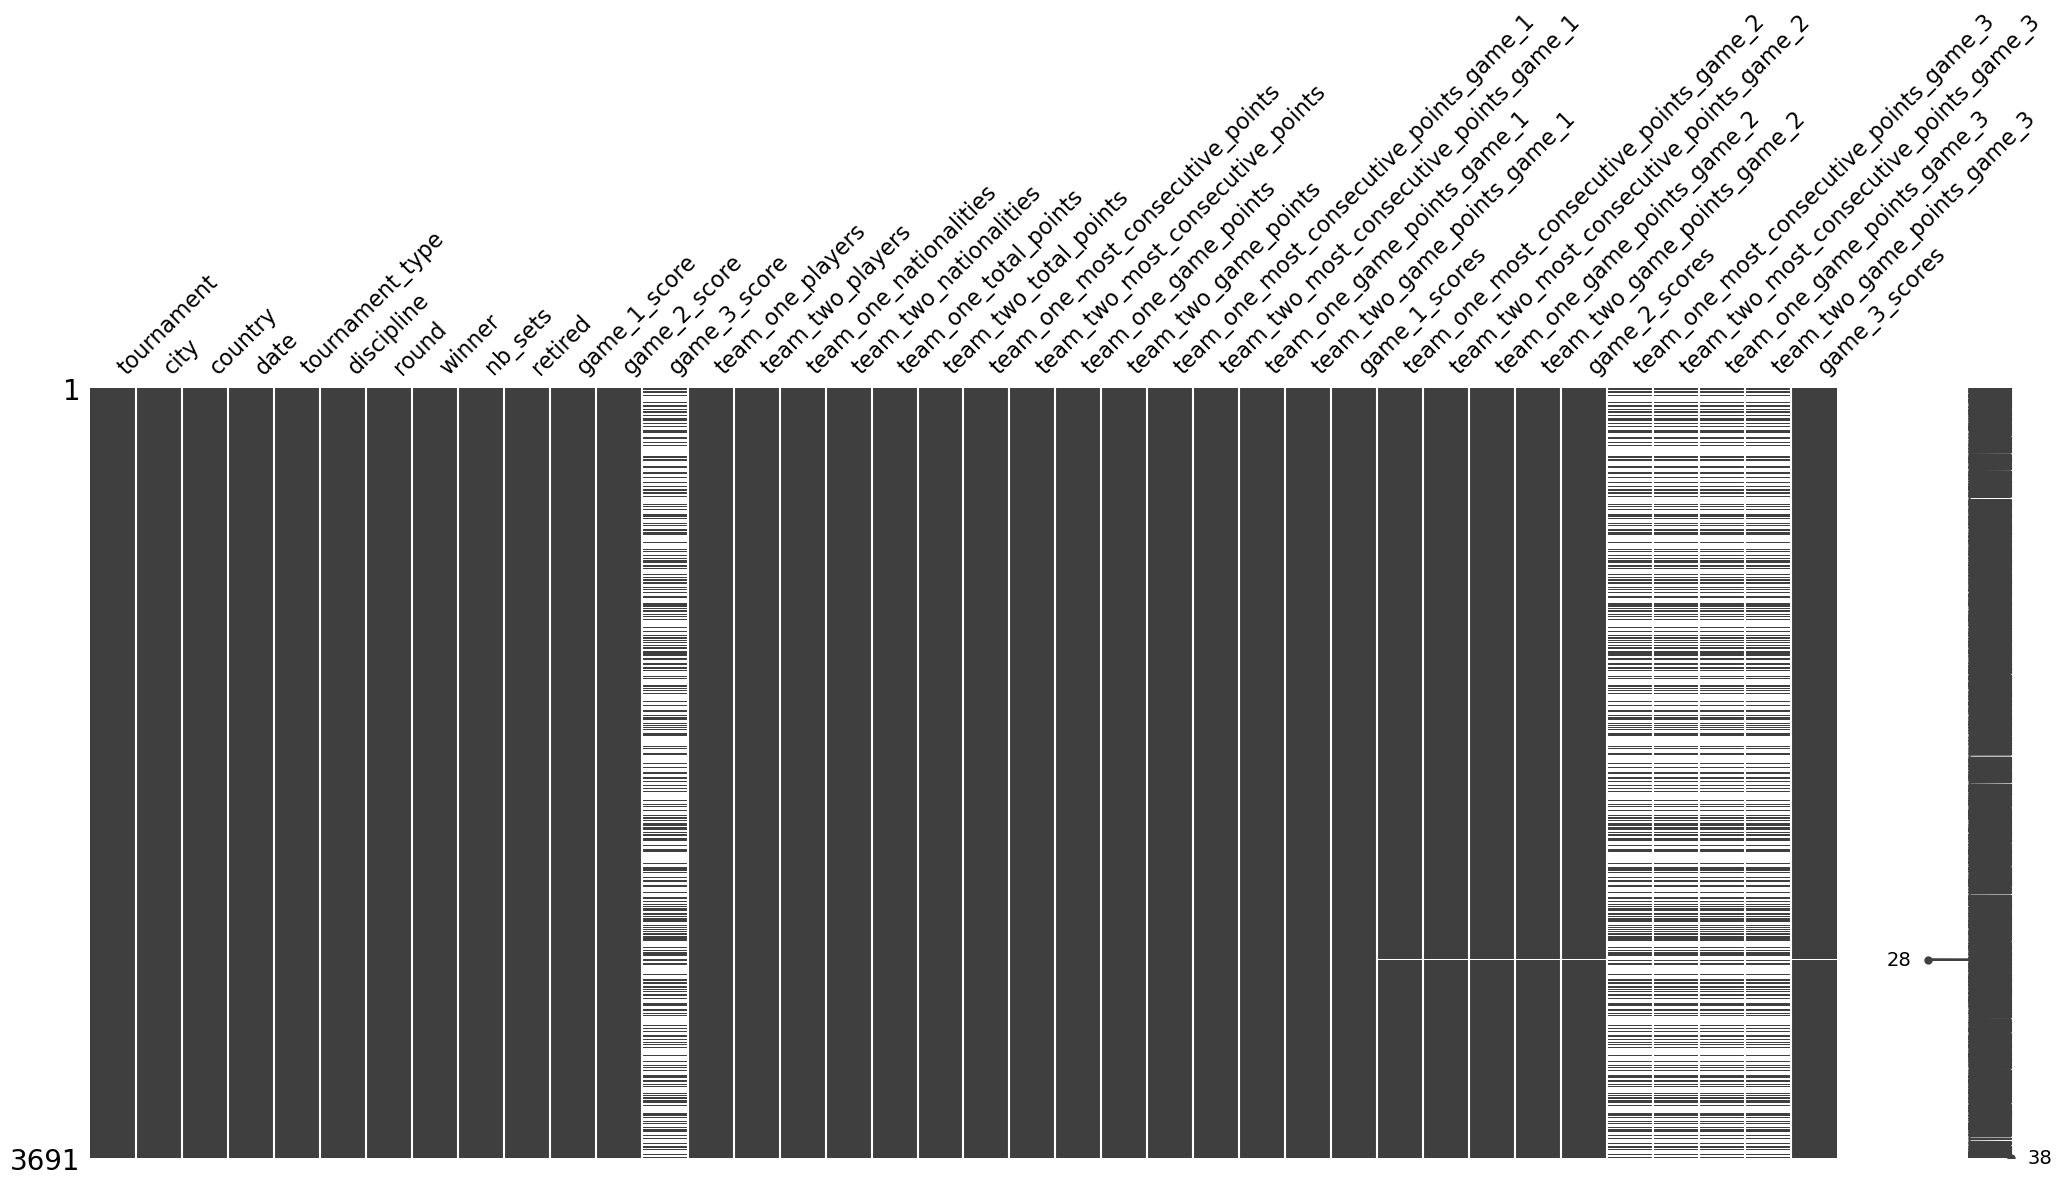

In [14]:
msno.matrix(ms)

## Preprocessing

First, we remove all entries that do not have a game 3

In [15]:
def filter_game_three(df):
    '''
    Filter out entires that dont contain game 3
    '''
    df = df.copy()
    df = df[df['nb_sets'] == 3]
    df.drop(2739, inplace = True) # Dropping this entry due to NaN values
    df.reset_index(inplace = True)
    df.drop(columns = 'index', inplace = True)
    return df

In [16]:
ms = filter_game_three(ms)

<Axes: >

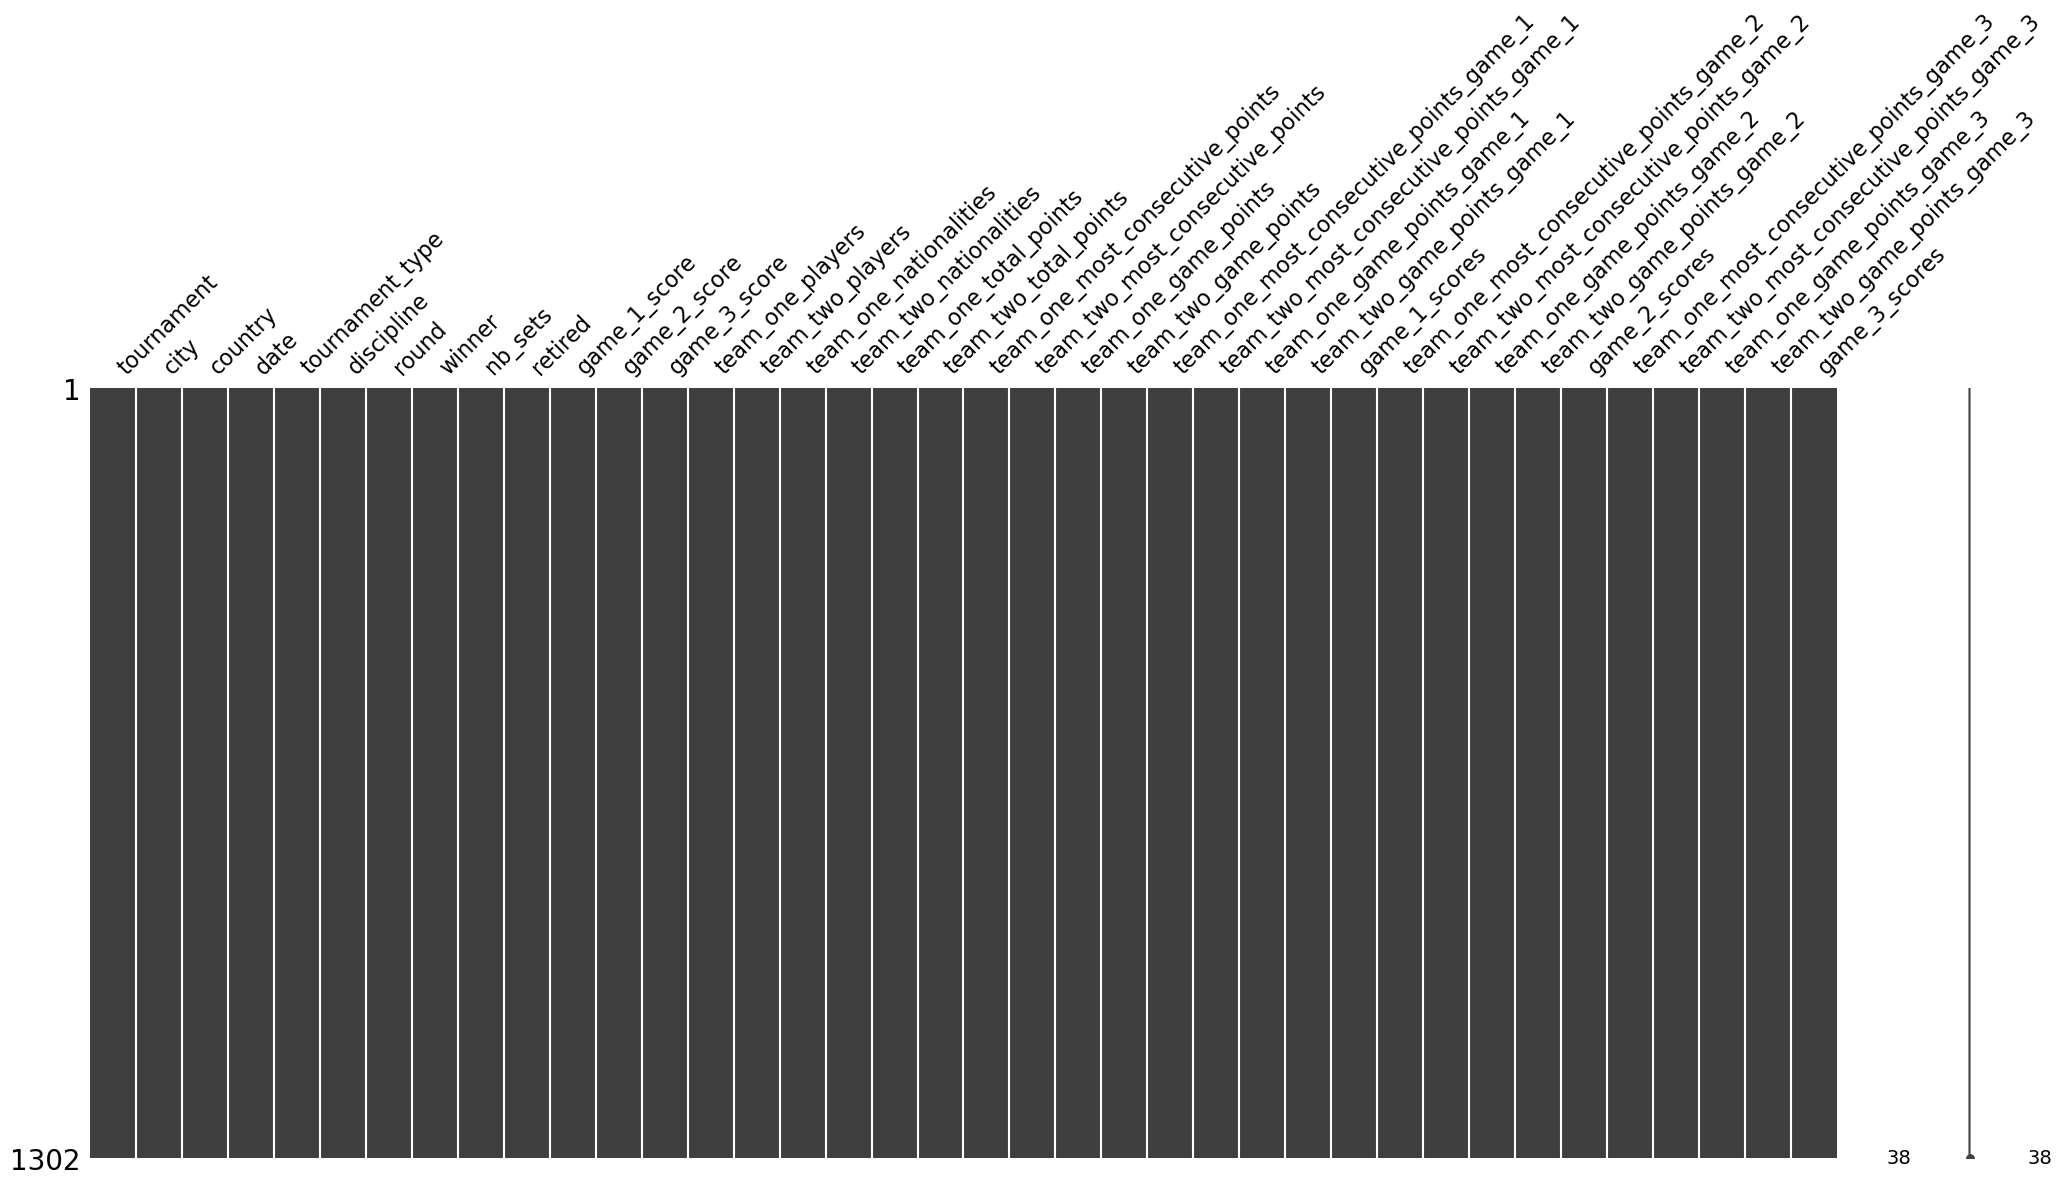

In [17]:
msno.matrix(ms)

In [18]:
na_df = ms[ms.isna().any(axis=1)]
na_df
# No rows without information

Empty DataFrame
Columns: [tournament, city, country, date, tournament_type, discipline, round, winner, nb_sets, retired, game_1_score, game_2_score, game_3_score, team_one_players, team_two_players, team_one_nationalities, team_two_nationalities, team_one_total_points, team_two_total_points, team_one_most_consecutive_points, team_two_most_consecutive_points, team_one_game_points, team_two_game_points, team_one_most_consecutive_points_game_1, team_two_most_consecutive_points_game_1, team_one_game_points_game_1, team_two_game_points_game_1, game_1_scores, team_one_most_consecutive_points_game_2, team_two_most_consecutive_points_game_2, team_one_game_points_game_2, team_two_game_points_game_2, game_2_scores, team_one_most_consecutive_points_game_3, team_two_most_consecutive_points_game_3, team_one_game_points_game_3, team_two_game_points_game_3, game_3_scores]
Index: []

[0 rows x 38 columns]

Now we have to remove all information that cannot be known before game 3.

In [19]:
ms.columns

Index(['tournament', 'city', 'country', 'date', 'tournament_type',
       'discipline', 'round', 'winner', 'nb_sets', 'retired', 'game_1_score',
       'game_2_score', 'game_3_score', 'team_one_players', 'team_two_players',
       'team_one_nationalities', 'team_two_nationalities',
       'team_one_total_points', 'team_two_total_points',
       'team_one_most_consecutive_points', 'team_two_most_consecutive_points',
       'team_one_game_points', 'team_two_game_points',
       'team_one_most_consecutive_points_game_1',
       'team_two_most_consecutive_points_game_1',
       'team_one_game_points_game_1', 'team_two_game_points_game_1',
       'game_1_scores', 'team_one_most_consecutive_points_game_2',
       'team_two_most_consecutive_points_game_2',
       'team_one_game_points_game_2', 'team_two_game_points_game_2',
       'game_2_scores', 'team_one_most_consecutive_points_game_3',
       'team_two_most_consecutive_points_game_3',
       'team_one_game_points_game_3', 'team_two_game_p

In [20]:
ms['game_3_score']

0        21-9
1       23-21
2       21-17
3        4-21
4        21-8
        ...  
1297    17-21
1298    19-21
1299    11-21
1300    21-11
1301    12-21
Name: game_3_score, Length: 1302, dtype: object

In [21]:
to_drop = ['discipline','retired', 'game_3_score','team_one_most_consecutive_points_game_3',
       'team_two_most_consecutive_points_game_3',
       'team_one_game_points_game_3', 'team_two_game_points_game_3',
       'game_3_scores']

In [22]:
ms = ms.drop(columns = to_drop)

In [23]:
ms.columns

Index(['tournament', 'city', 'country', 'date', 'tournament_type', 'round',
       'winner', 'nb_sets', 'game_1_score', 'game_2_score', 'team_one_players',
       'team_two_players', 'team_one_nationalities', 'team_two_nationalities',
       'team_one_total_points', 'team_two_total_points',
       'team_one_most_consecutive_points', 'team_two_most_consecutive_points',
       'team_one_game_points', 'team_two_game_points',
       'team_one_most_consecutive_points_game_1',
       'team_two_most_consecutive_points_game_1',
       'team_one_game_points_game_1', 'team_two_game_points_game_1',
       'game_1_scores', 'team_one_most_consecutive_points_game_2',
       'team_two_most_consecutive_points_game_2',
       'team_one_game_points_game_2', 'team_two_game_points_game_2',
       'game_2_scores'],
      dtype='object')

In [24]:
ms.iloc[1]['game_1_scores']

"['0-0', '1-0', '2-0', '2-1', '3-1', '4-1', '5-1', '6-1', '6-2', '7-2', '8-2', '9-2', '9-3', '9-4', '10-4', '11-4', '12-4', '13-4', '13-5', '13-6', '13-7', '13-8', '14-8', '15-8', '15-9', '16-9', '16-10', '16-11', '16-12', '16-13', '17-13', '17-14', '17-15', '18-15', '19-15', '20-15', '20-16', '21-16']"

In [25]:
ms.info()

numeric_columns = ms.select_dtypes(include='number').columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tournament                               1302 non-null   object 
 1   city                                     1302 non-null   object 
 2   country                                  1302 non-null   object 
 3   date                                     1302 non-null   object 
 4   tournament_type                          1302 non-null   object 
 5   round                                    1302 non-null   object 
 6   winner                                   1302 non-null   int64  
 7   nb_sets                                  1302 non-null   int64  
 8   game_1_score                             1302 non-null   object 
 9   game_2_score                             1302 non-null   object 
 10  team_one_players                         1302 no

## Feature engineering

In [26]:
ms['target'] = ms['winner'].map({1 : 0, 2 : 1})

In [27]:
# Generating column of player who won

ms["winner_player"] = ms.apply(lambda row: row["team_two_players"] if row["target"] else row["team_one_players"], axis=1)

## Visualisations

<Axes: xlabel='team_one_most_consecutive_points_game_1', ylabel='Count'>

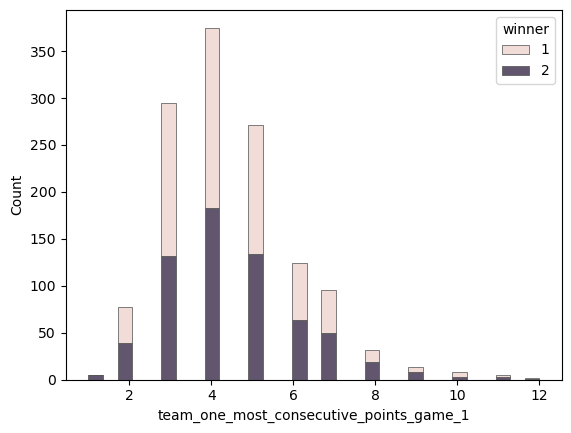

In [28]:
sns.histplot(
    ms,
    x="team_one_most_consecutive_points_game_1", hue="winner",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)

<Axes: >

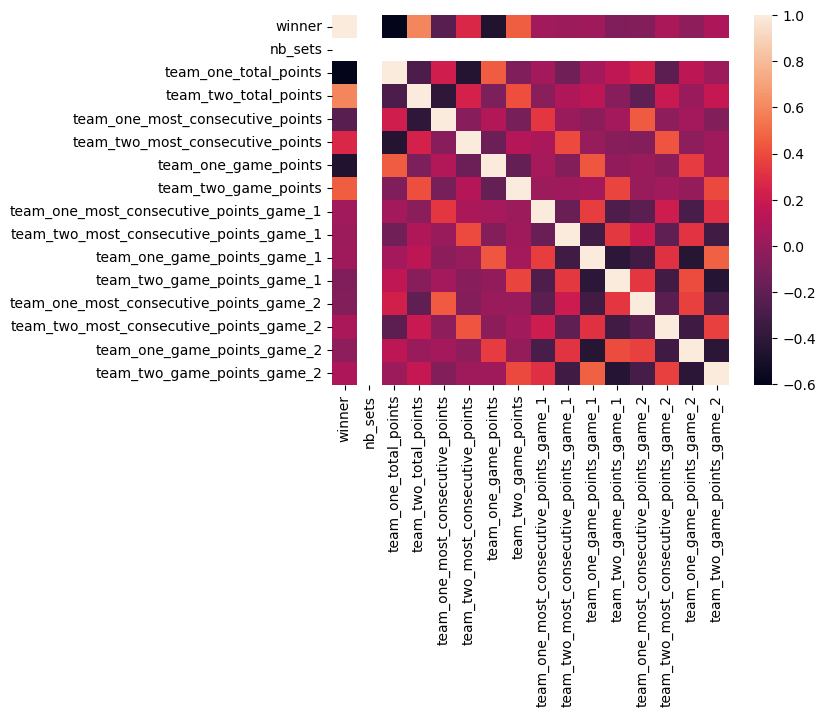

In [55]:
# most correlated with winning variables
corr = ms[numeric_columns].corr()
sns.heatmap(corr)

<Axes: >

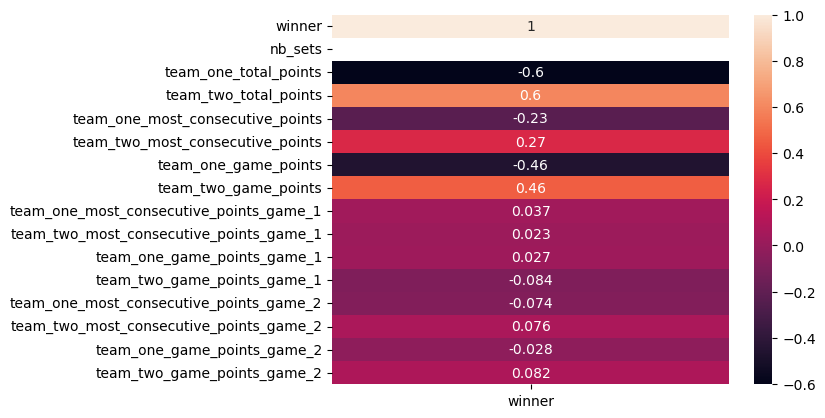

In [58]:
sns.heatmap(corr[['winner']],
           annot = True)

# Interestingly game 1 total points is the most uncorrelated with the winning value

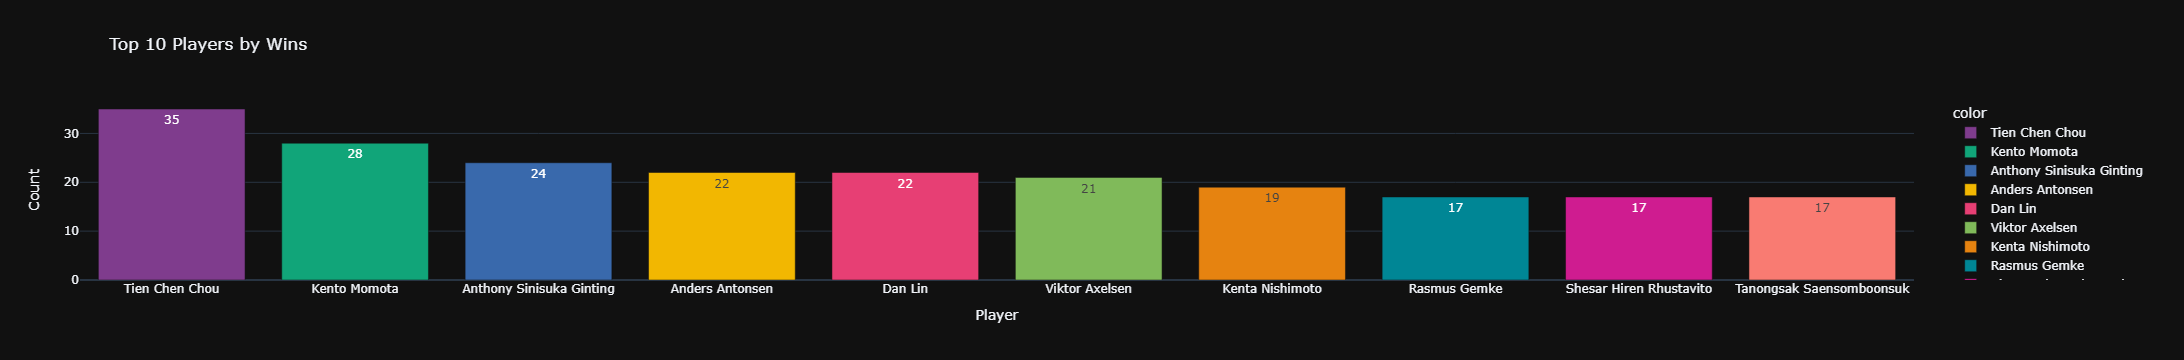

In [30]:
# Players with the most wins
top_10 = ms["winner_player"].value_counts()[:10]
fig = px.bar(y=top_10.values, 
             x=top_10.index, 
             color = top_10.index,
             color_discrete_sequence=px.colors.qualitative.Bold,
             text=top_10.values,
             title= 'Top 10 Players by Wins',
             template= 'plotly_dark')
fig.update_layout(
    xaxis_title="Player",
    yaxis_title="Count")
fig.show()

In [31]:
player_games = dict(ms['team_one_players'].value_counts())

for key, value in dict(ms['team_two_players'].value_counts()).items():
    if key in player_games:
        player_games[key] = player_games[key] + value

In [32]:
winners =  ms["winner_player"].value_counts()

In [33]:
def get_win_percent(player):
    return winners[player] / player_games[player]

In [34]:
win_percentages = {player: get_win_percent(player) for player in winners.index if (player in player_games) and (player_games[player] >5) }
win_percentages = dict(sorted(win_percentages.items(), key=lambda item: item[1], reverse = True))

In [35]:
# Players with the most win%
temp_df = pd.DataFrame(list(win_percentages.items())[:10]).set_index(0)

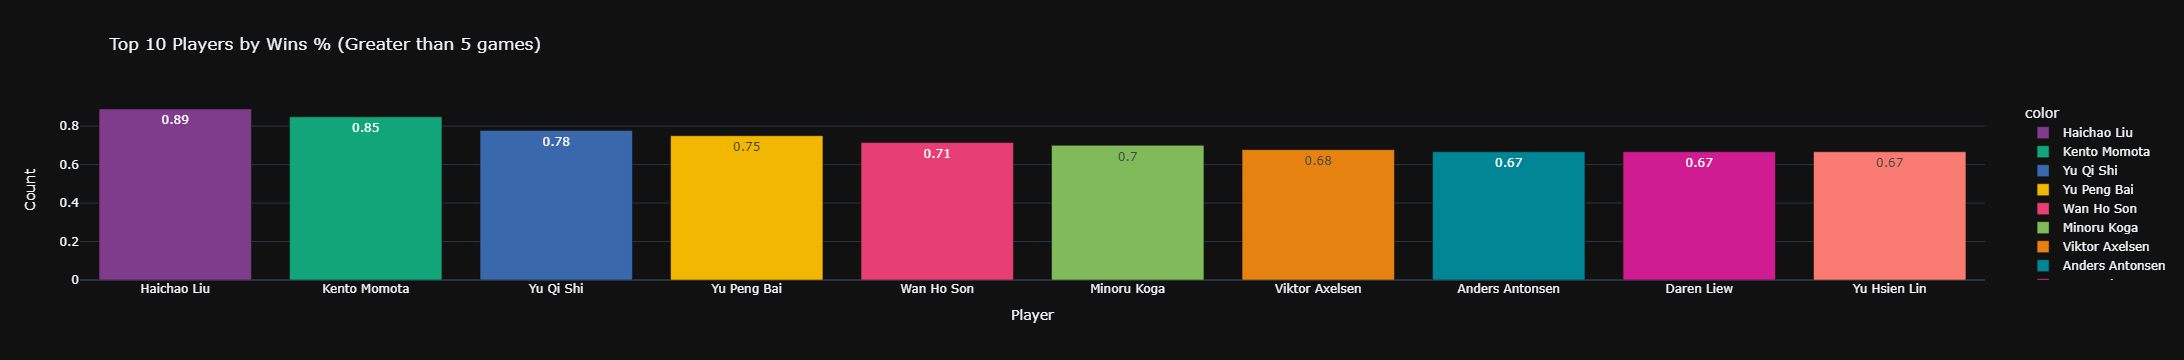

In [36]:
fig = px.bar(y=temp_df.values.squeeze(), 
             x=temp_df.index, 
             color = temp_df.index,
             color_discrete_sequence=px.colors.qualitative.Bold,
             text= temp_df.values.squeeze().round(2),
             title= 'Top 10 Players by Wins % (Greater than 5 games)',
             template= 'plotly_dark')
fig.update_layout(
    xaxis_title="Player",
    yaxis_title="Count")
fig.show()

# Training design

- 1. For each game, turn into a pd.series? So turn game points into 1. player 1 streak, player 2 streak etc. shove all that information into predicting game outcome and you can see for each point, the win %

## Monte Carlo Simulation

In [37]:
# Generating fake time series data

In [38]:
test_df = ms.iloc[:5].copy()

In [39]:
test_df.columns

Index(['tournament', 'city', 'country', 'date', 'tournament_type', 'round',
       'winner', 'nb_sets', 'game_1_score', 'game_2_score', 'team_one_players',
       'team_two_players', 'team_one_nationalities', 'team_two_nationalities',
       'team_one_total_points', 'team_two_total_points',
       'team_one_most_consecutive_points', 'team_two_most_consecutive_points',
       'team_one_game_points', 'team_two_game_points',
       'team_one_most_consecutive_points_game_1',
       'team_two_most_consecutive_points_game_1',
       'team_one_game_points_game_1', 'team_two_game_points_game_1',
       'game_1_scores', 'team_one_most_consecutive_points_game_2',
       'team_two_most_consecutive_points_game_2',
       'team_one_game_points_game_2', 'team_two_game_points_game_2',
       'game_2_scores', 'target', 'winner_player'],
      dtype='object')

In [41]:
test_df['game_1_score'].apply(lambda x: x.split("-")[0])

0    11
1    21
2    18
3    22
4    21
Name: game_1_score, dtype: object

In [42]:
test_df['game_1_score']

0    11-21
1    21-16
2    18-21
3    22-20
4     21-8
Name: game_1_score, dtype: object

In [43]:
s = 'game_1_score'
print(s[:6])

game_1


In [63]:
def extract_points(df, column):
    df[column[:6] + '_player_1_points'] = df[column].apply(lambda x: x.split("-")[0]).astype("int64")
    df[column[:6]+ '_player_2_points'] = df[column].apply(lambda x: x.split("-")[1]).astype("int64")
    return df

In [64]:
for column in ['game_1_score', 'game_2_score']:
     test_df = extract_points(test_df, column)

In [65]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 36 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tournament                               5 non-null      object 
 1   city                                     5 non-null      object 
 2   country                                  5 non-null      object 
 3   date                                     5 non-null      object 
 4   tournament_type                          5 non-null      object 
 5   round                                    5 non-null      object 
 6   winner                                   5 non-null      int64  
 7   nb_sets                                  5 non-null      int64  
 8   game_1_score                             5 non-null      object 
 9   game_2_score                             5 non-null      object 
 10  team_one_players                         5 non-null   

<Axes: >

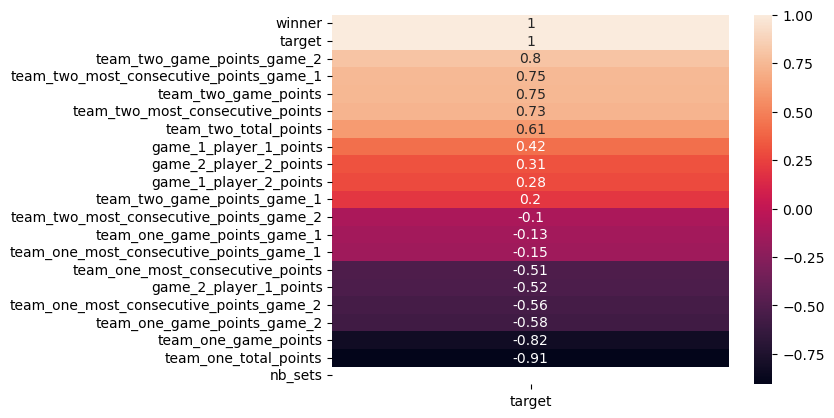

In [72]:

numeric_columns_test = test_df.select_dtypes(include='number').columns
sns.heatmap(test_df[numeric_columns_test].corr()[['target']].sort_values(by = ['target'], ascending = False),
           annot = True)


In [ ]:
pd.DataFrame(cols)